# Crytocurrency price forecasting using Neural Networks
### Author : Prafulla Ranjan Dash

In [1]:
#! pip install optuna

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as R_squared
from sklearn.metrics import explained_variance_score as EVS

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from collections import OrderedDict

from statsmodels.tsa.stattools import acf
import statsmodels.tsa.api as smt


# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

C:\Users\HP\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\HP\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [3]:
data_path = 'D:/USMS/UChicago/STUDIES/Autumn 2020/MSCA 31009 2 Machine Learning & Predictive Analytics/Final Project/data/'

In [4]:
# importing the data
BTC_USD = pd.read_csv(data_path+'BTC-USD.csv')
BTC_USD.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,23-11-15,324.350006,325.118011,321.290009,323.045990,323.045990,27478900
1,24-11-15,323.014008,323.058014,318.118011,320.045990,320.045990,29362600
2,25-11-15,320.045013,329.134003,316.769989,328.205994,328.205994,41666900
3,26-11-15,328.303009,366.756989,328.229004,352.683990,352.683990,106105000
4,27-11-15,351.860992,363.588989,347.869995,358.041992,358.041992,55179100


In [5]:
# importing the data
XRP_USD = pd.read_csv(data_path+'XRP-USD.csv')
XRP_USD.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-11-23,0.004269,0.004351,0.004237,0.004288,0.004288,314451
1,2015-11-24,0.004288,0.004288,0.004201,0.004242,0.004242,197940
2,2015-11-25,0.004242,0.004325,0.004228,0.004318,0.004318,197356
3,2015-11-26,0.004317,0.004435,0.004227,0.004291,0.004291,400520
4,2015-11-27,0.004276,0.004304,0.004229,0.004276,0.004276,199790


In [6]:
# importing the data
ETH_USD = pd.read_csv(data_path+'ETH-USD.csv')
ETH_USD.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-11-26,0.863273,0.903643,0.804360,0.884183,0.884183,947473
1,2015-11-27,0.882100,0.900051,0.860695,0.867951,0.867951,403813
2,2015-11-28,0.868102,0.929293,0.862122,0.915703,0.915703,462464
3,2015-11-29,0.914144,0.914153,0.860533,0.878614,0.878614,448358
4,2015-11-30,0.879951,0.895054,0.847696,0.873119,0.873119,784439


Visualizing the data

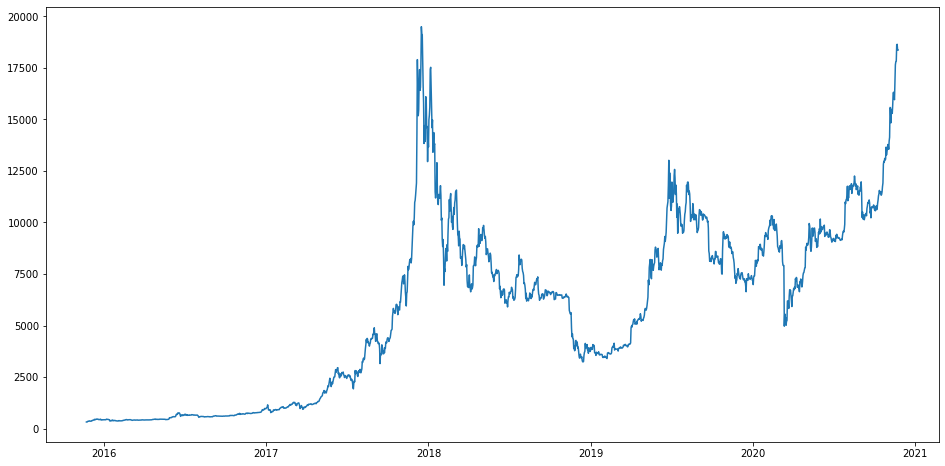

In [7]:
#setting index as date
BTC_USD['Date'] = pd.to_datetime(BTC_USD.Date,format='%d-%m-%y')
BTC_USD.index = BTC_USD['Date']

#plot
plt.figure(figsize=(16,8))
plt.plot(BTC_USD['Adj Close'], label='Close Price history')
plt.show()

In [8]:
acf(BTC_USD['Adj Close'])

array([1.        , 0.99423422, 0.98836081, 0.98243877, 0.97655391,
       0.9711072 , 0.96516856, 0.95954192, 0.95443923, 0.94948489,
       0.94431207, 0.9383486 , 0.9323998 , 0.9267217 , 0.92151832,
       0.91645611, 0.91124988, 0.90654012, 0.90133098, 0.89617373,
       0.89112366, 0.88566904, 0.88052372, 0.87528015, 0.87024479,
       0.86550755, 0.86064368, 0.85578418, 0.8510254 , 0.84640555,
       0.84175072, 0.83686147, 0.8321526 , 0.82781362, 0.82324624,
       0.81918155, 0.81535443, 0.81188781, 0.80839156, 0.80494398,
       0.80113257])

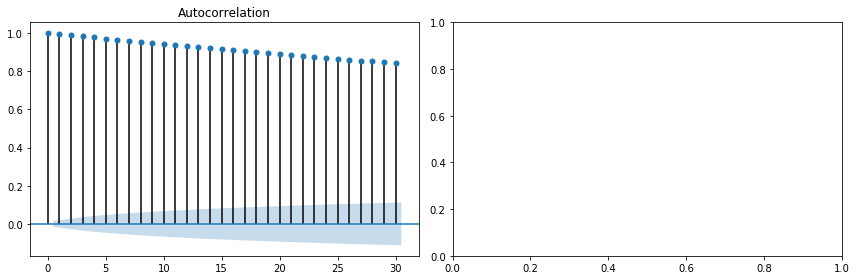

In [9]:
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(12)
fig.set_figheight(4)
_ = smt.graphics.plot_acf(BTC_USD['Adj Close'], lags=30, ax=axes[0], alpha=0.5)
plt.tight_layout()

Linear Regression is not designed to capture the short term dynamics or the autocorrelations which are present in this sequential data. It is more designed to look at the data globally and capture the global trend. We need a model that is able to capture the short term dynamics and short term dependencies within our dataset.

We can see there is **autocorrelation** between the observations (prices of the bitcoin), hence we have to apply models that can capture this autocorrelation and make effective predictions

In the world of Neural Networks, we have something called **Recurrent Neural Networks** which is designed to capture these dependencies. Let's apply this and see how it performs in predicting the Bitcoin prices

In [10]:
BTC_USD.head()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2015-11-23,2015-11-23,324.350006,325.118011,321.290009,323.045990,323.045990,27478900
2015-11-24,2015-11-24,323.014008,323.058014,318.118011,320.045990,320.045990,29362600
2015-11-25,2015-11-25,320.045013,329.134003,316.769989,328.205994,328.205994,41666900
2015-11-26,2015-11-26,328.303009,366.756989,328.229004,352.683990,352.683990,106105000
2015-11-27,2015-11-27,351.860992,363.588989,347.869995,358.041992,358.041992,55179100


In [11]:
BTC_USD.reset_index(drop=True,inplace=True)

In [12]:
BTC_USD.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-11-23,324.350006,325.118011,321.290009,323.045990,323.045990,27478900
1,2015-11-24,323.014008,323.058014,318.118011,320.045990,320.045990,29362600
2,2015-11-25,320.045013,329.134003,316.769989,328.205994,328.205994,41666900
3,2015-11-26,328.303009,366.756989,328.229004,352.683990,352.683990,106105000
4,2015-11-27,351.860992,363.588989,347.869995,358.041992,358.041992,55179100


In [13]:
BTC_USD.shape

(1828, 7)

### Making the data ready for feeding to the RNNs

In [14]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [15]:
# fix random seed for reproducibility
np.random.seed(5)

In [16]:
# take adjusted close price column
bitcoin_y = BTC_USD['Adj Close'].values
bitcoin_dataset=bitcoin_y.reshape(-1, 1)

In [17]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
bitcoin_dataset = scaler.fit_transform(bitcoin_dataset)

In [18]:
# split into train and test sets, 25% test data, 75% training data
bitcoin_train_size = int(len(bitcoin_dataset) * 0.75)
bitcoin_test_size = len(bitcoin_dataset) - bitcoin_train_size
bitcoin_train, bitcoin_test = bitcoin_dataset[0:bitcoin_train_size,:], bitcoin_dataset[bitcoin_train_size:len(bitcoin_dataset),:]

In [19]:
# reshape into X=t and Y=t+1, timestep 240
look_back = 240
bitcoin_trainX, bitcoin_trainY = create_dataset(bitcoin_train, look_back)
bitcoin_testX, bitcoin_testY = create_dataset(bitcoin_test, look_back)

In [20]:
# reshape input to be [samples, time steps, features]
bitcoin_trainX = np.reshape(bitcoin_trainX, (bitcoin_trainX.shape[0], 1, bitcoin_trainX.shape[1]))
bitcoin_testX = np.reshape(bitcoin_testX, (bitcoin_testX.shape[0], 1, bitcoin_testX.shape[1]))

### Simple RNN

In [21]:
# using 10 epochs
model_RNN = Sequential()
model_RNN.add(SimpleRNN(64,activation = 'relu',return_sequences= True))
model_RNN.add(SimpleRNN(8,activation = 'relu'))
model_RNN.add(Dense(128,activation = 'relu'))
model_RNN.add(Dense(1))
model_RNN.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
model_RNN_fitted_e10 = model_RNN.fit(bitcoin_trainX, bitcoin_trainY, epochs=10, batch_size=240, verbose=1)

Epoch 1/10
5/5 [==============================] - ETA: 0s - loss: 0.1547 - mean_squared_error: 0.15 - 0s 4ms/step - loss: 0.1115 - mean_squared_error: 0.1115
Epoch 2/10
5/5 [==============================] - ETA: 0s - loss: 0.0574 - mean_squared_error: 0.05 - 0s 4ms/step - loss: 0.0391 - mean_squared_error: 0.0391
Epoch 3/10
5/5 [==============================] - ETA: 0s - loss: 0.0185 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0219 - mean_squared_error: 0.0219
Epoch 4/10
5/5 [==============================] - ETA: 0s - loss: 0.0167 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0122 - mean_squared_error: 0.0122
Epoch 5/10
5/5 [==============================] - ETA: 0s - loss: 0.0112 - mean_squared_error: 0.01 - 0s 5ms/step - loss: 0.0116 - mean_squared_error: 0.0116
Epoch 6/10
5/5 [==============================] - ETA: 0s - loss: 0.0091 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0085 - mean_squared_error: 0.0085
Epoch 7/10
5/5 [==============================] - ET

In [22]:
# make predictions
bitcoin_trainPredict_RNN = model_RNN.predict(bitcoin_trainX)
bitcoin_testPredict_RNN = model_RNN.predict(bitcoin_testX)

In [23]:
len(bitcoin_testPredict_RNN)

216

In [24]:
# calculate root mean squared error
bitcoin_trainScore = np.sqrt(MSE(bitcoin_trainY, bitcoin_trainPredict_RNN))
print('Train RMSE for the bitcoin LSTM: %.2f' % (bitcoin_trainScore))
bitcoin_testScore = np.sqrt(MSE(bitcoin_testY, bitcoin_testPredict_RNN))
print('Test RMSE for the bitcoin LSTM: %.2f' % (bitcoin_testScore))

Train RMSE for the bitcoin LSTM: 0.07
Test RMSE for the bitcoin LSTM: 0.10


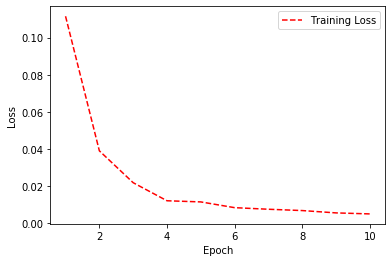

In [25]:
# Get training loss histories
training_loss = model_RNN_fitted_e10.history['loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

We see that using 10 epochs resulted in reasonablly good predictions. But there is a hint of overfitting here as the train RMSE is less than test RMSE. Let's try with more epochs

In [26]:
# using 100 epochs
model_RNN = Sequential()
model_RNN.add(SimpleRNN(64,activation = 'relu',return_sequences= True))
model_RNN.add(SimpleRNN(8,activation = 'relu'))
model_RNN.add(Dense(128,activation = 'relu'))
model_RNN.add(Dense(1))
model_RNN.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
model_RNN_fitted_e100 = model_RNN.fit(bitcoin_trainX, bitcoin_trainY, epochs=100, batch_size=240, verbose=1)

Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.1226 - mean_squared_error: 0.12 - 0s 5ms/step - loss: 0.0601 - mean_squared_error: 0.0601
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.0279 - mean_squared_error: 0.02 - 0s 4ms/step - loss: 0.0279 - mean_squared_error: 0.0279
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.0150 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0163 - mean_squared_error: 0.0163
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.0122 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0121 - mean_squared_error: 0.0121
Epoch 5/100
5/5 [==============================] - ETA: 0s - loss: 0.0091 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0088 - mean_squared_error: 0.0088
Epoch 6/100
5/5 [==============================] - ETA: 0s - loss: 0.0081 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 7/100
5/5 [=============================

Epoch 51/100
5/5 [==============================] - ETA: 0s - loss: 0.0011 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 8.7303e-04 - mean_squared_error: 8.7303e-04
Epoch 52/100
5/5 [==============================] - ETA: 0s - loss: 6.1320e-04 - mean_squared_error: 6.1320e- - 0s 4ms/step - loss: 8.6540e-04 - mean_squared_error: 8.6540e-04
Epoch 53/100
5/5 [==============================] - ETA: 0s - loss: 6.6568e-04 - mean_squared_error: 6.6568e- - 0s 4ms/step - loss: 8.3199e-04 - mean_squared_error: 8.3199e-04
Epoch 54/100
5/5 [==============================] - ETA: 0s - loss: 9.8091e-04 - mean_squared_error: 9.8091e- - 0s 4ms/step - loss: 8.2856e-04 - mean_squared_error: 8.2856e-04
Epoch 55/100
5/5 [==============================] - ETA: 0s - loss: 9.6236e-04 - mean_squared_error: 9.6236e- - 0s 4ms/step - loss: 8.2223e-04 - mean_squared_error: 8.2223e-04
Epoch 56/100
5/5 [==============================] - ETA: 0s - loss: 9.6788e-04 - mean_squared_error: 9.6788e- - 0s 4ms/step - lo

Epoch 98/100
5/5 [==============================] - ETA: 0s - loss: 7.4896e-04 - mean_squared_error: 7.4896e- - 0s 4ms/step - loss: 5.7588e-04 - mean_squared_error: 5.7588e-04
Epoch 99/100
5/5 [==============================] - ETA: 0s - loss: 3.3921e-04 - mean_squared_error: 3.3921e- - 0s 5ms/step - loss: 5.8622e-04 - mean_squared_error: 5.8622e-04
Epoch 100/100
5/5 [==============================] - ETA: 0s - loss: 5.6442e-04 - mean_squared_error: 5.6442e- - 0s 5ms/step - loss: 6.6069e-04 - mean_squared_error: 6.6069e-04


In [27]:
# make predictions
bitcoin_trainPredict_RNN = model_RNN.predict(bitcoin_trainX)
bitcoin_testPredict_RNN = model_RNN.predict(bitcoin_testX)

In [28]:
# calculate root mean squared error
bitcoin_trainScore = np.sqrt(MSE(bitcoin_trainY, bitcoin_trainPredict_RNN))
print('Train RMSE for the bitcoin LSTM: %.2f' % (bitcoin_trainScore))
bitcoin_testScore = np.sqrt(MSE(bitcoin_testY, bitcoin_testPredict_RNN))
print('Test RMSE for the bitcoin LSTM: %.2f' % (bitcoin_testScore))

Train RMSE for the bitcoin LSTM: 0.02
Test RMSE for the bitcoin LSTM: 0.05


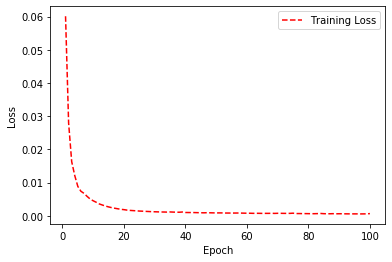

In [29]:
# Get training loss histories
training_loss = model_RNN_fitted_e100.history['loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

Here, we can see that the loss is decreasing very rapidly initially, but as it is closer to the optimal point (zero), it's rate of reduction is slowing down

We now see that even after increasing the number of epochs, the performance of the simple RNN model improved just a little bit. Also, there is still some overfitting. The RNNS are also prone to **Vanishing Gradient Problem**, but here it is not visible even though there are many layers.

So, to solve the Vanishing Gradient problem in general, we can use **LSTM (Long Short Term Memory)**

### LSTM - Long Short Term Memory

In [30]:
# create and fit the LSTM network, optimizer=adam, 25 neurons, dropout 0.1
bitcoin_lstm_model = Sequential()
bitcoin_lstm_model.add(LSTM(25, input_shape=(1, look_back)))
bitcoin_lstm_model.add(Dropout(0.1))
bitcoin_lstm_model.add(Dense(1, activation = 'relu'))
bitcoin_lstm_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
bitcoin_lstm_model_fitted = bitcoin_lstm_model.fit(bitcoin_trainX, bitcoin_trainY, epochs=100, batch_size=240, verbose=1)

Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.1127 - mean_squared_error: 0.11 - 0s 5ms/step - loss: 0.0536 - mean_squared_error: 0.0536
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.0321 - mean_squared_error: 0.03 - 0s 5ms/step - loss: 0.0289 - mean_squared_error: 0.0289
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.0168 - mean_squared_error: 0.01 - 0s 5ms/step - loss: 0.0137 - mean_squared_error: 0.0137
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.0152 - mean_squared_error: 0.01 - 0s 5ms/step - loss: 0.0124 - mean_squared_error: 0.0124
Epoch 5/100
5/5 [==============================] - ETA: 0s - loss: 0.0086 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0085 - mean_squared_error: 0.0085
Epoch 6/100
5/5 [==============================] - ETA: 0s - loss: 0.0093 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0083 - mean_squared_error: 0.0083
Epoch 7/100
5/5 [=============================

5/5 [==============================] - ETA: 0s - loss: 0.0017 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 53/100
5/5 [==============================] - ETA: 0s - loss: 0.0019 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 54/100
5/5 [==============================] - ETA: 0s - loss: 0.0020 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 55/100
5/5 [==============================] - ETA: 0s - loss: 0.0019 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 56/100
5/5 [==============================] - ETA: 0s - loss: 0.0017 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 57/100
5/5 [==============================] - ETA: 0s - loss: 0.0017 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 58/100
5/5 [==============================] - E

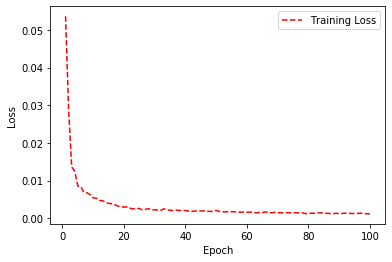

In [31]:
# loss function for LSTM model
# Get training loss histories
training_loss = bitcoin_lstm_model_fitted.history['loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [32]:
# make predictions
bitcoin_trainPredict = bitcoin_lstm_model.predict(bitcoin_trainX)
bitcoin_testPredict = bitcoin_lstm_model.predict(bitcoin_testX)

In [33]:
# calculate root mean squared error
bitcoin_trainScore = np.sqrt(MSE(bitcoin_trainY, bitcoin_trainPredict))
print('Train RMSE for the bitcoin LSTM: %.2f' % (bitcoin_trainScore))
bitcoin_testScore = np.sqrt(MSE(bitcoin_testY, bitcoin_testPredict))
print('Test RMSE for the bitcoin LSTM: %.2f' % (bitcoin_testScore))

Train RMSE for the bitcoin LSTM: 0.03
Test RMSE for the bitcoin LSTM: 0.06


So, using LSTM we have seen **marked improvement** in the performance of the model and it is now making much **better predictions**. The model is fitting very well as the gap between the train and test error is very less.

Also, here we are following the principle of **Exploitation** of Machine learning where we are using the same hyperparameters for more number of epochs for getting the best results.

In [34]:
# invert predictions
bitcoin_trainPredict_reverted = scaler.inverse_transform(bitcoin_trainPredict)
bitcoin_trainY_reverted = scaler.inverse_transform([bitcoin_trainY])
bitcoin_testPredict_reverted = scaler.inverse_transform(bitcoin_testPredict)
bitcoin_testY_reverted = scaler.inverse_transform([bitcoin_testY])

In [35]:
# shift train predictions for plotting
bitcoin_trainPredictPlot = np.empty_like(bitcoin_dataset)
bitcoin_trainPredictPlot[:, :] = np.nan
bitcoin_trainPredictPlot[look_back:len(bitcoin_trainPredict_reverted)+look_back, :] = bitcoin_trainPredict_reverted

In [36]:
# shift test predictions for plotting
bitcoin_testPredictPlot = np.empty_like(bitcoin_dataset)
bitcoin_testPredictPlot[:, :] = np.nan
bitcoin_testPredictPlot[len(bitcoin_trainPredict_reverted)+(look_back*2)+1:len(bitcoin_dataset)-1, :] = bitcoin_testPredict_reverted

Text(0, 0.5, 'Bitcoin Prices in USD')

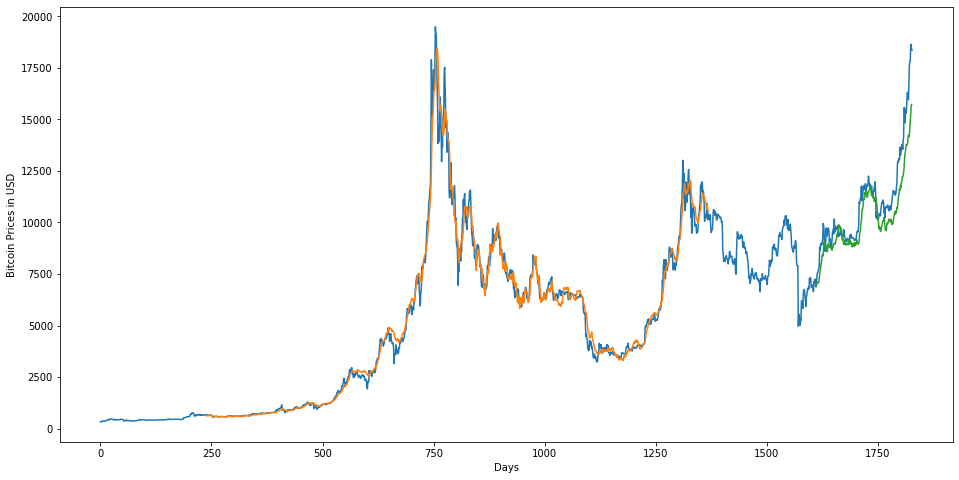

In [37]:
# plot baseline and predictions
plt.figure(figsize=(16,8))
plt.plot(scaler.inverse_transform(bitcoin_dataset))
plt.plot(bitcoin_trainPredictPlot)
plt.plot(bitcoin_testPredictPlot)
plt.xlabel('Days')
plt.ylabel('Bitcoin Prices in USD')

Now, let's try using a different optimizer - **Stochastic Gradient Descent** for LSTM

In [38]:
# create and fit the LSTM network, optimizer=SGD, 25 neurons, dropout 0.1
bitcoin_lstm_model = Sequential()
bitcoin_lstm_model.add(LSTM(25, input_shape=(1, look_back)))
bitcoin_lstm_model.add(Dropout(0.1))
bitcoin_lstm_model.add(Dense(1, activation = 'relu'))
bitcoin_lstm_model.compile(loss='mean_squared_error', optimizer='SGD',metrics=['mean_squared_error'])
bitcoin_lstm_model.fit(bitcoin_trainX, bitcoin_trainY, epochs=100, batch_size=240, verbose=1)

Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.0960 - mean_squared_error: 0.09 - 0s 5ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.1088 - mean_squared_error: 0.10 - 0s 5ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.1286 - mean_squared_error: 0.12 - 0s 5ms/step - loss: 0.1062 - mean_squared_error: 0.1062
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.1065 - mean_squared_error: 0.10 - 0s 5ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 5/100
5/5 [==============================] - ETA: 0s - loss: 0.0999 - mean_squared_error: 0.09 - 0s 5ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 6/100
5/5 [==============================] - ETA: 0s - loss: 0.1175 - mean_squared_error: 0.11 - 0s 5ms/step - loss: 0.1062 - mean_squared_error: 0.1062
Epoch 7/100
5/5 [=============================

5/5 [==============================] - ETA: 0s - loss: 0.0991 - mean_squared_error: 0.09 - 0s 5ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 53/100
5/5 [==============================] - ETA: 0s - loss: 0.1026 - mean_squared_error: 0.10 - 0s 6ms/step - loss: 0.1061 - mean_squared_error: 0.1061
Epoch 54/100
5/5 [==============================] - ETA: 0s - loss: 0.1112 - mean_squared_error: 0.11 - 0s 5ms/step - loss: 0.1062 - mean_squared_error: 0.1062
Epoch 55/100
5/5 [==============================] - ETA: 0s - loss: 0.1153 - mean_squared_error: 0.11 - 0s 5ms/step - loss: 0.1063 - mean_squared_error: 0.1063
Epoch 56/100
5/5 [==============================] - ETA: 0s - loss: 0.1069 - mean_squared_error: 0.10 - 0s 5ms/step - loss: 0.1062 - mean_squared_error: 0.1062
Epoch 57/100
5/5 [==============================] - ETA: 0s - loss: 0.1085 - mean_squared_error: 0.10 - 0s 6ms/step - loss: 0.1062 - mean_squared_error: 0.1062
Epoch 58/100
5/5 [==============================] - E

In [39]:
# make predictions
bitcoin_trainPredict = bitcoin_lstm_model.predict(bitcoin_trainX)
bitcoin_testPredict = bitcoin_lstm_model.predict(bitcoin_testX)

In [40]:
# calculate root mean squared error
bitcoin_trainScore = np.sqrt(MSE(bitcoin_trainY, bitcoin_trainPredict))
print('Train RMSE for the bitcoin LSTM: %.2f' % (bitcoin_trainScore))
bitcoin_testScore = np.sqrt(MSE(bitcoin_testY, bitcoin_testPredict))
print('Test RMSE for the bitcoin LSTM: %.2f' % (bitcoin_testScore))

Train RMSE for the bitcoin LSTM: 0.12
Test RMSE for the bitcoin LSTM: 0.13


We see **Stochastic Gradient Descent** is not that effective as **ADAM** when it comes to optimizing the cost function

Using a different optimizer - **AdaGrad**

In [41]:
# create and fit the LSTM network, optimizer=Adagrad, 25 neurons, dropout 0.1
bitcoin_lstm_model = Sequential()
bitcoin_lstm_model.add(LSTM(25, input_shape=(1, look_back)))
bitcoin_lstm_model.add(Dropout(0.1))
bitcoin_lstm_model.add(Dense(1))
bitcoin_lstm_model.compile(loss='mean_squared_error', optimizer='Adagrad',metrics=['mean_squared_error'])
bitcoin_lstm_model.fit(bitcoin_trainX, bitcoin_trainY, epochs=100, batch_size=240, verbose=1)

Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.1796 - mean_squared_error: 0.17 - 0s 5ms/step - loss: 0.1626 - mean_squared_error: 0.1626
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.1438 - mean_squared_error: 0.14 - 0s 5ms/step - loss: 0.1501 - mean_squared_error: 0.1501
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.1473 - mean_squared_error: 0.14 - 0s 4ms/step - loss: 0.1415 - mean_squared_error: 0.1415
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.1507 - mean_squared_error: 0.15 - 0s 5ms/step - loss: 0.1303 - mean_squared_error: 0.1303
Epoch 5/100
5/5 [==============================] - ETA: 0s - loss: 0.1433 - mean_squared_error: 0.14 - 0s 5ms/step - loss: 0.1209 - mean_squared_error: 0.1209
Epoch 6/100
5/5 [==============================] - ETA: 0s - loss: 0.1063 - mean_squared_error: 0.10 - 0s 5ms/step - loss: 0.1131 - mean_squared_error: 0.1131
Epoch 7/100
5/5 [=============================

5/5 [==============================] - ETA: 0s - loss: 0.0254 - mean_squared_error: 0.02 - 0s 5ms/step - loss: 0.0277 - mean_squared_error: 0.0277
Epoch 53/100
5/5 [==============================] - ETA: 0s - loss: 0.0258 - mean_squared_error: 0.02 - 0s 5ms/step - loss: 0.0289 - mean_squared_error: 0.0289
Epoch 54/100
5/5 [==============================] - ETA: 0s - loss: 0.0303 - mean_squared_error: 0.03 - 0s 5ms/step - loss: 0.0277 - mean_squared_error: 0.0277
Epoch 55/100
5/5 [==============================] - ETA: 0s - loss: 0.0226 - mean_squared_error: 0.02 - 0s 4ms/step - loss: 0.0275 - mean_squared_error: 0.0275
Epoch 56/100
5/5 [==============================] - ETA: 0s - loss: 0.0337 - mean_squared_error: 0.03 - 0s 4ms/step - loss: 0.0268 - mean_squared_error: 0.0268
Epoch 57/100
5/5 [==============================] - ETA: 0s - loss: 0.0169 - mean_squared_error: 0.01 - 0s 6ms/step - loss: 0.0268 - mean_squared_error: 0.0268
Epoch 58/100
5/5 [==============================] - E

In [42]:
# make predictions
bitcoin_trainPredict = bitcoin_lstm_model.predict(bitcoin_trainX)
bitcoin_testPredict = bitcoin_lstm_model.predict(bitcoin_testX)

In [43]:
# calculate root mean squared error
bitcoin_trainScore = np.sqrt(MSE(bitcoin_trainY, bitcoin_trainPredict))
print('Train RMSE for the bitcoin LSTM: %.2f' % (bitcoin_trainScore))
bitcoin_testScore = np.sqrt(MSE(bitcoin_testY, bitcoin_testPredict))
print('Test RMSE for the bitcoin LSTM: %.2f' % (bitcoin_testScore))

Train RMSE for the bitcoin LSTM: 0.14
Test RMSE for the bitcoin LSTM: 0.15


**AdaGrad** also not performing that well, when compared to **ADAM**

### Hyperparameter tuning using Optuna

Now, let's try to tune our hyperparameters for the LSTM model to get the optimal parameters using **Optuna**

In [44]:
# defining the objective function
def objective(trial):
    units = trial.suggest_int('units', 2, 25)
    rate = trial.suggest_int('rate', 0.1, 0.9)
    #epochs = trial.suggest_int('epochs', 10, 100)
    bitcoin_lstm_model = Sequential()
    bitcoin_lstm_model.add(LSTM(units, input_shape=(1, look_back)))
    bitcoin_lstm_model.add(Dropout(rate))
    bitcoin_lstm_model.add(Dense(1))
    bitcoin_lstm_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    bitcoin_lstm_model.fit(bitcoin_trainX, bitcoin_trainY, epochs=100, batch_size=240, verbose=1)
    # make predictions
    bitcoin_trainPredict = bitcoin_lstm_model.predict(bitcoin_trainX)
    bitcoin_testPredict = bitcoin_lstm_model.predict(bitcoin_testX)
    
    bitcoin_trainScore = round(np.sqrt(MSE(bitcoin_trainY, bitcoin_trainPredict)),2)
    bitcoin_testScore = round(np.sqrt(MSE(bitcoin_testY, bitcoin_testPredict)),2)
    return bitcoin_testScore

Here, we have created the **study** object which contains all the information about the required parameter space.

In [45]:
# creating study object
study = optuna.create_study(direction='minimize')

# calling the optimize function
study.optimize(objective, n_trials=10)

[I 2020-12-10 18:45:30,143] A new study created in memory with name: no-name-53124849-5bd9-478d-9aeb-720057ba2a88


Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.2792 - mean_squared_error: 0.27 - 0s 4ms/step - loss: 0.2241 - mean_squared_error: 0.2241
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.1327 - mean_squared_error: 0.13 - 0s 4ms/step - loss: 0.1253 - mean_squared_error: 0.1253
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.0810 - mean_squared_error: 0.08 - 0s 4ms/step - loss: 0.0771 - mean_squared_error: 0.0771
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.0607 - mean_squared_error: 0.06 - 0s 5ms/step - loss: 0.0502 - mean_squared_error: 0.0502
Epoch 5/100
5/5 [==============================] - ETA: 0s - loss: 0.0371 - mean_squared_error: 0.03 - 0s 4ms/step - loss: 0.0335 - mean_squared_error: 0.0335
Epoch 6/100
5/5 [==============================] - ETA: 0s - loss: 0.0320 - mean_squared_error: 0.03 - 0s 4ms/step - loss: 0.0245 - mean_squared_error: 0.0245
Epoch 7/100
5/5 [=============================

5/5 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 53/100
5/5 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 54/100
5/5 [==============================] - ETA: 0s - loss: 0.0022 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 55/100
5/5 [==============================] - ETA: 0s - loss: 0.0026 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 56/100
5/5 [==============================] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 57/100
5/5 [==============================] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 58/100
5/5 [==============================] - E

[I 2020-12-10 18:45:38,465] Trial 0 finished with value: 0.09 and parameters: {'units': 5, 'rate': 0}. Best is trial 0 with value: 0.09.


Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.0320 - mean_squared_error: 0.03 - 0s 4ms/step - loss: 0.0266 - mean_squared_error: 0.0266
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.0147 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0109 - mean_squared_error: 0.0109
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.0075 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.0075 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 5/100
5/5 [==============================] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 6/100
5/5 [==============================] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 7/100
5/5 [=============================

5/5 [==============================] - ETA: 0s - loss: 7.6350e-04 - mean_squared_error: 7.6350e- - 0s 5ms/step - loss: 9.8983e-04 - mean_squared_error: 9.8983e-04
Epoch 52/100
5/5 [==============================] - ETA: 0s - loss: 0.0010 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 53/100
5/5 [==============================] - ETA: 0s - loss: 8.7477e-04 - mean_squared_error: 8.7477e- - 0s 4ms/step - loss: 0.0011 - mean_squared_error: 0.0011    
Epoch 54/100
5/5 [==============================] - ETA: 0s - loss: 0.0013 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 55/100
5/5 [==============================] - ETA: 0s - loss: 0.0011 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 56/100
5/5 [==============================] - ETA: 0s - loss: 7.6512e-04 - mean_squared_error: 7.6512e- - 0s 4ms/step - loss: 9.4922e-04 - mean_squared_error: 9.4922e-04
Epoch 57/

5/5 [==============================] - ETA: 0s - loss: 9.3270e-04 - mean_squared_error: 9.3270e- - 0s 4ms/step - loss: 6.5097e-04 - mean_squared_error: 6.5097e-04
Epoch 99/100
5/5 [==============================] - ETA: 0s - loss: 7.9178e-04 - mean_squared_error: 7.9178e- - 0s 4ms/step - loss: 6.3166e-04 - mean_squared_error: 6.3166e-04
Epoch 100/100
5/5 [==============================] - ETA: 0s - loss: 4.7316e-04 - mean_squared_error: 4.7316e- - 0s 4ms/step - loss: 6.4703e-04 - mean_squared_error: 6.4703e-04


[I 2020-12-10 18:45:46,970] Trial 1 finished with value: 0.08 and parameters: {'units': 10, 'rate': 0}. Best is trial 1 with value: 0.08.


Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.0603 - mean_squared_error: 0.06 - 0s 4ms/step - loss: 0.0522 - mean_squared_error: 0.0522
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.0328 - mean_squared_error: 0.03 - 0s 4ms/step - loss: 0.0330 - mean_squared_error: 0.0330
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.0229 - mean_squared_error: 0.02 - 0s 4ms/step - loss: 0.0252 - mean_squared_error: 0.0252
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.0185 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0180 - mean_squared_error: 0.0180
Epoch 5/100
5/5 [==============================] - ETA: 0s - loss: 0.0119 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0141 - mean_squared_error: 0.0141
Epoch 6/100
5/5 [==============================] - ETA: 0s - loss: 0.0100 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0111 - mean_squared_error: 0.0111
Epoch 7/100
5/5 [=============================

5/5 [==============================] - ETA: 0s - loss: 0.0016 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 53/100
5/5 [==============================] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 54/100
5/5 [==============================] - ETA: 0s - loss: 0.0015 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 55/100
5/5 [==============================] - ETA: 0s - loss: 0.0015 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 56/100
5/5 [==============================] - ETA: 0s - loss: 0.0021 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 57/100
5/5 [==============================] - ETA: 0s - loss: 0.0016 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 58/100
5/5 [==============================] - E

[I 2020-12-10 18:45:54,946] Trial 2 finished with value: 0.11 and parameters: {'units': 4, 'rate': 0}. Best is trial 1 with value: 0.08.


Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.1068 - mean_squared_error: 0.10 - 0s 4ms/step - loss: 0.0646 - mean_squared_error: 0.0646
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.0298 - mean_squared_error: 0.02 - 0s 4ms/step - loss: 0.0333 - mean_squared_error: 0.0333
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.0232 - mean_squared_error: 0.02 - 0s 5ms/step - loss: 0.0214 - mean_squared_error: 0.0214
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.0140 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0142 - mean_squared_error: 0.0142
Epoch 5/100
5/5 [==============================] - ETA: 0s - loss: 0.0117 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0116 - mean_squared_error: 0.0116
Epoch 6/100
5/5 [==============================] - ETA: 0s - loss: 0.0097 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0080 - mean_squared_error: 0.0080
Epoch 7/100
5/5 [=============================

5/5 [==============================] - ETA: 0s - loss: 0.0017 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 53/100
5/5 [==============================] - ETA: 0s - loss: 0.0013 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 54/100
5/5 [==============================] - ETA: 0s - loss: 0.0020 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 55/100
5/5 [==============================] - ETA: 0s - loss: 0.0019 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 56/100
5/5 [==============================] - ETA: 0s - loss: 0.0013 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 57/100
5/5 [==============================] - ETA: 0s - loss: 0.0014 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 58/100
5/5 [==============================] - E

[I 2020-12-10 18:46:03,656] Trial 3 finished with value: 0.08 and parameters: {'units': 15, 'rate': 0}. Best is trial 1 with value: 0.08.


Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.1206 - mean_squared_error: 0.12 - 0s 4ms/step - loss: 0.0944 - mean_squared_error: 0.0944
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.0484 - mean_squared_error: 0.04 - 0s 4ms/step - loss: 0.0416 - mean_squared_error: 0.0416
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.0293 - mean_squared_error: 0.02 - 0s 4ms/step - loss: 0.0298 - mean_squared_error: 0.0298
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.0207 - mean_squared_error: 0.02 - 0s 4ms/step - loss: 0.0222 - mean_squared_error: 0.0222
Epoch 5/100
5/5 [==============================] - ETA: 0s - loss: 0.0224 - mean_squared_error: 0.02 - 0s 4ms/step - loss: 0.0169 - mean_squared_error: 0.0169
Epoch 6/100
5/5 [==============================] - ETA: 0s - loss: 0.0181 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0139 - mean_squared_error: 0.0139
Epoch 7/100
5/5 [=============================

5/5 [==============================] - ETA: 0s - loss: 0.0026 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 53/100
5/5 [==============================] - ETA: 0s - loss: 0.0019 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 54/100
5/5 [==============================] - ETA: 0s - loss: 0.0018 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 55/100
5/5 [==============================] - ETA: 0s - loss: 0.0018 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 56/100
5/5 [==============================] - ETA: 0s - loss: 0.0026 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 57/100
5/5 [==============================] - ETA: 0s - loss: 0.0018 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 58/100
5/5 [==============================] - E

[I 2020-12-10 18:46:12,291] Trial 4 finished with value: 0.09 and parameters: {'units': 8, 'rate': 0}. Best is trial 1 with value: 0.08.


Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.1304 - mean_squared_error: 0.13 - 0s 4ms/step - loss: 0.0941 - mean_squared_error: 0.0941
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.0605 - mean_squared_error: 0.06 - 0s 4ms/step - loss: 0.0436 - mean_squared_error: 0.0436
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.0389 - mean_squared_error: 0.03 - 0s 4ms/step - loss: 0.0302 - mean_squared_error: 0.0302
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.0177 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0185 - mean_squared_error: 0.0185
Epoch 5/100
5/5 [==============================] - ETA: 0s - loss: 0.0151 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0146 - mean_squared_error: 0.0146
Epoch 6/100
5/5 [==============================] - ETA: 0s - loss: 0.0148 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0112 - mean_squared_error: 0.0112
Epoch 7/100
5/5 [=============================

5/5 [==============================] - ETA: 0s - loss: 0.0016 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 53/100
5/5 [==============================] - ETA: 0s - loss: 0.0016 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 54/100
5/5 [==============================] - ETA: 0s - loss: 0.0017 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 55/100
5/5 [==============================] - ETA: 0s - loss: 0.0017 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 56/100
5/5 [==============================] - ETA: 0s - loss: 0.0016 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 57/100
5/5 [==============================] - ETA: 0s - loss: 0.0013 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 58/100
5/5 [==============================] - E

[I 2020-12-10 18:46:20,962] Trial 5 finished with value: 0.06 and parameters: {'units': 11, 'rate': 0}. Best is trial 5 with value: 0.06.


Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.1026 - mean_squared_error: 0.10 - 0s 4ms/step - loss: 0.0816 - mean_squared_error: 0.0816
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.0451 - mean_squared_error: 0.04 - 0s 4ms/step - loss: 0.0352 - mean_squared_error: 0.0352
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.0203 - mean_squared_error: 0.02 - 0s 4ms/step - loss: 0.0223 - mean_squared_error: 0.0223
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.0232 - mean_squared_error: 0.02 - 0s 4ms/step - loss: 0.0206 - mean_squared_error: 0.0206
Epoch 5/100
5/5 [==============================] - ETA: 0s - loss: 0.0164 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0153 - mean_squared_error: 0.0153
Epoch 6/100
5/5 [==============================] - ETA: 0s - loss: 0.0153 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0120 - mean_squared_error: 0.0120
Epoch 7/100
5/5 [=============================

5/5 [==============================] - ETA: 0s - loss: 0.0017 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 53/100
5/5 [==============================] - ETA: 0s - loss: 0.0015 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 54/100
5/5 [==============================] - ETA: 0s - loss: 0.0015 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 55/100
5/5 [==============================] - ETA: 0s - loss: 0.0014 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 56/100
5/5 [==============================] - ETA: 0s - loss: 0.0013 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 57/100
5/5 [==============================] - ETA: 0s - loss: 0.0019 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 58/100
5/5 [==============================] - E

[I 2020-12-10 18:46:29,108] Trial 6 finished with value: 0.08 and parameters: {'units': 7, 'rate': 0}. Best is trial 5 with value: 0.06.


Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.1523 - mean_squared_error: 0.15 - 0s 5ms/step - loss: 0.0794 - mean_squared_error: 0.0794
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.0266 - mean_squared_error: 0.02 - 0s 4ms/step - loss: 0.0353 - mean_squared_error: 0.0353
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.0352 - mean_squared_error: 0.03 - 0s 5ms/step - loss: 0.0231 - mean_squared_error: 0.0231
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.0130 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0127 - mean_squared_error: 0.0127
Epoch 5/100
5/5 [==============================] - ETA: 0s - loss: 0.0117 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0123 - mean_squared_error: 0.0123
Epoch 6/100
5/5 [==============================] - ETA: 0s - loss: 0.0107 - mean_squared_error: 0.01 - 0s 5ms/step - loss: 0.0083 - mean_squared_error: 0.0083
Epoch 7/100
5/5 [=============================

Epoch 52/100
5/5 [==============================] - ETA: 0s - loss: 0.0013 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 53/100
5/5 [==============================] - ETA: 0s - loss: 0.0019 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 54/100
5/5 [==============================] - ETA: 0s - loss: 0.0015 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 55/100
5/5 [==============================] - ETA: 0s - loss: 0.0015 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 56/100
5/5 [==============================] - ETA: 0s - loss: 0.0015 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 57/100
5/5 [==============================] - ETA: 0s - loss: 0.0013 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 58/100
5/5 [======================

[I 2020-12-10 18:46:38,250] Trial 7 finished with value: 0.07 and parameters: {'units': 16, 'rate': 0}. Best is trial 5 with value: 0.06.


Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.1060 - mean_squared_error: 0.10 - 0s 6ms/step - loss: 0.0541 - mean_squared_error: 0.0541
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.0502 - mean_squared_error: 0.05 - 0s 5ms/step - loss: 0.0333 - mean_squared_error: 0.0333
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.0195 - mean_squared_error: 0.01 - 0s 5ms/step - loss: 0.0154 - mean_squared_error: 0.0154
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.0142 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0119 - mean_squared_error: 0.0119
Epoch 5/100
5/5 [==============================] - ETA: 0s - loss: 0.0071 - mean_squared_error: 0.00 - 0s 6ms/step - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 6/100
5/5 [==============================] - ETA: 0s - loss: 0.0072 - mean_squared_error: 0.00 - 0s 6ms/step - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 7/100
5/5 [=============================

5/5 [==============================] - ETA: 0s - loss: 0.0015 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 53/100
5/5 [==============================] - ETA: 0s - loss: 0.0011 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 54/100
5/5 [==============================] - ETA: 0s - loss: 0.0013 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 55/100
5/5 [==============================] - ETA: 0s - loss: 0.0015 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 56/100
5/5 [==============================] - ETA: 0s - loss: 9.3813e-04 - mean_squared_error: 9.3813e- - 0s 5ms/step - loss: 0.0012 - mean_squared_error: 0.0012    
Epoch 57/100
5/5 [==============================] - ETA: 0s - loss: 0.0011 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 58/100
5/5 [=======================

[I 2020-12-10 18:46:46,893] Trial 8 finished with value: 0.06 and parameters: {'units': 25, 'rate': 0}. Best is trial 5 with value: 0.06.


Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.1089 - mean_squared_error: 0.10 - 0s 5ms/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.0291 - mean_squared_error: 0.02 - 0s 5ms/step - loss: 0.0292 - mean_squared_error: 0.0292
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.0216 - mean_squared_error: 0.02 - 0s 5ms/step - loss: 0.0133 - mean_squared_error: 0.0133
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.0155 - mean_squared_error: 0.01 - 0s 5ms/step - loss: 0.0127 - mean_squared_error: 0.0127
Epoch 5/100
5/5 [==============================] - ETA: 0s - loss: 0.0107 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0082 - mean_squared_error: 0.0082
Epoch 6/100
5/5 [==============================] - ETA: 0s - loss: 0.0081 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 7/100
5/5 [=============================

5/5 [==============================] - ETA: 0s - loss: 0.0012 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 53/100
5/5 [==============================] - ETA: 0s - loss: 0.0014 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 54/100
5/5 [==============================] - ETA: 0s - loss: 0.0014 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 55/100
5/5 [==============================] - ETA: 0s - loss: 0.0017 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 56/100
5/5 [==============================] - ETA: 0s - loss: 9.6965e-04 - mean_squared_error: 9.6965e- - 0s 5ms/step - loss: 0.0012 - mean_squared_error: 0.0012    
Epoch 57/100
5/5 [==============================] - ETA: 0s - loss: 0.0012 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 58/100
5/5 [=======================

5/5 [==============================] - ETA: 0s - loss: 5.3590e-04 - mean_squared_error: 5.3590e- - 0s 4ms/step - loss: 6.8424e-04 - mean_squared_error: 6.8424e-04


[I 2020-12-10 18:46:55,751] Trial 9 finished with value: 0.08 and parameters: {'units': 21, 'rate': 0}. Best is trial 5 with value: 0.06.


In [46]:
# best test error
trial = study.best_trial
print('Best test error: {}'.format(trial.value))

Best test error: 0.06


In [47]:
# best hyperparameters
print("Best hyperparameters: {}".format(trial.params))

Best hyperparameters: {'units': 11, 'rate': 0}


So, we saw that using **Optuna**, we got the best hyperparameters of **number of LSTM units** and **number of dropout nodes** as **19** and **0** respectively. Similarly, we can use this to tune other hyperparameters as well.

Let's try optimizing the number of **epochs** and **batch_size**

In [48]:
# defining the objective function
def objective(trial):
    units = trial.suggest_int('units', 2, 25)
    rate = trial.suggest_int('rate', 0.1, 0.9)
    epochs = trial.suggest_int('epochs', 10, 100)
    batch_size = trial.suggest_int('batch_size', 100, 300)
    bitcoin_lstm_model = Sequential()
    bitcoin_lstm_model.add(LSTM(units, input_shape=(1, look_back)))
    bitcoin_lstm_model.add(Dropout(rate))
    bitcoin_lstm_model.add(Dense(1))
    bitcoin_lstm_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    bitcoin_lstm_model.fit(bitcoin_trainX, bitcoin_trainY, epochs=epochs, batch_size=240, verbose=1)
    # make predictions
    bitcoin_trainPredict = bitcoin_lstm_model.predict(bitcoin_trainX)
    bitcoin_testPredict = bitcoin_lstm_model.predict(bitcoin_testX)
    
    bitcoin_trainScore = round(np.sqrt(MSE(bitcoin_trainY, bitcoin_trainPredict)),2)
    bitcoin_testScore = round(np.sqrt(MSE(bitcoin_testY, bitcoin_testPredict)),2)
    return bitcoin_testScore

In [49]:
# creating study object
study = optuna.create_study(direction='minimize')

# calling the optimize function
study.optimize(objective, n_trials=10)

[I 2020-12-10 18:46:55,900] A new study created in memory with name: no-name-930c49e4-deb7-4fcd-86f4-468b4fd8660e


Epoch 1/46
5/5 [==============================] - ETA: 0s - loss: 0.1371 - mean_squared_error: 0.13 - 0s 6ms/step - loss: 0.0568 - mean_squared_error: 0.0568
Epoch 2/46
5/5 [==============================] - ETA: 0s - loss: 0.0322 - mean_squared_error: 0.03 - 0s 4ms/step - loss: 0.0299 - mean_squared_error: 0.0299
Epoch 3/46
5/5 [==============================] - ETA: 0s - loss: 0.0187 - mean_squared_error: 0.01 - 0s 5ms/step - loss: 0.0129 - mean_squared_error: 0.0129
Epoch 4/46
5/5 [==============================] - ETA: 0s - loss: 0.0088 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0120 - mean_squared_error: 0.0120
Epoch 5/46
5/5 [==============================] - ETA: 0s - loss: 0.0100 - mean_squared_error: 0.01 - 0s 5ms/step - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 6/46
5/5 [==============================] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 7/46
5/5 [==============================] - ET

[I 2020-12-10 18:47:02,393] Trial 0 finished with value: 0.08 and parameters: {'units': 21, 'rate': 0, 'epochs': 46, 'batch_size': 295}. Best is trial 0 with value: 0.08.


Epoch 1/48
5/5 [==============================] - ETA: 0s - loss: 0.1061 - mean_squared_error: 0.10 - 0s 4ms/step - loss: 0.0771 - mean_squared_error: 0.0771
Epoch 2/48
5/5 [==============================] - ETA: 0s - loss: 0.0410 - mean_squared_error: 0.04 - 0s 4ms/step - loss: 0.0358 - mean_squared_error: 0.0358
Epoch 3/48
5/5 [==============================] - ETA: 0s - loss: 0.0289 - mean_squared_error: 0.02 - 0s 4ms/step - loss: 0.0271 - mean_squared_error: 0.0271
Epoch 4/48
5/5 [==============================] - ETA: 0s - loss: 0.0261 - mean_squared_error: 0.02 - 0s 4ms/step - loss: 0.0212 - mean_squared_error: 0.0212
Epoch 5/48
5/5 [==============================] - ETA: 0s - loss: 0.0215 - mean_squared_error: 0.02 - 0s 4ms/step - loss: 0.0158 - mean_squared_error: 0.0158
Epoch 6/48
5/5 [==============================] - ETA: 0s - loss: 0.0125 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0131 - mean_squared_error: 0.0131
Epoch 7/48
5/5 [==============================] - ET

[I 2020-12-10 18:47:09,306] Trial 1 finished with value: 0.13 and parameters: {'units': 3, 'rate': 0, 'epochs': 48, 'batch_size': 154}. Best is trial 0 with value: 0.08.


Epoch 1/92
5/5 [==============================] - ETA: 0s - loss: 0.0899 - mean_squared_error: 0.08 - 0s 5ms/step - loss: 0.0677 - mean_squared_error: 0.0677
Epoch 2/92
5/5 [==============================] - ETA: 0s - loss: 0.0297 - mean_squared_error: 0.02 - 0s 4ms/step - loss: 0.0220 - mean_squared_error: 0.0220
Epoch 3/92
5/5 [==============================] - ETA: 0s - loss: 0.0228 - mean_squared_error: 0.02 - 0s 4ms/step - loss: 0.0209 - mean_squared_error: 0.0209
Epoch 4/92
5/5 [==============================] - ETA: 0s - loss: 0.0172 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0141 - mean_squared_error: 0.0141
Epoch 5/92
5/5 [==============================] - ETA: 0s - loss: 0.0096 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0101 - mean_squared_error: 0.0101
Epoch 6/92
5/5 [==============================] - ETA: 0s - loss: 0.0110 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0093 - mean_squared_error: 0.0093
Epoch 7/92
5/5 [==============================] - ET

5/5 [==============================] - ETA: 0s - loss: 0.0018 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 53/92
5/5 [==============================] - ETA: 0s - loss: 0.0013 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 54/92
5/5 [==============================] - ETA: 0s - loss: 0.0014 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 55/92
5/5 [==============================] - ETA: 0s - loss: 0.0012 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 56/92
5/5 [==============================] - ETA: 0s - loss: 0.0012 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 57/92
5/5 [==============================] - ETA: 0s - loss: 0.0013 - mean_squared_error: 0.00 - 0s 6ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 58/92
5/5 [==============================] - ETA: 0s

[I 2020-12-10 18:47:17,515] Trial 2 finished with value: 0.06 and parameters: {'units': 8, 'rate': 0, 'epochs': 92, 'batch_size': 253}. Best is trial 2 with value: 0.06.


Epoch 1/49
5/5 [==============================] - ETA: 0s - loss: 0.1381 - mean_squared_error: 0.13 - 0s 6ms/step - loss: 0.0795 - mean_squared_error: 0.0795
Epoch 2/49
5/5 [==============================] - ETA: 0s - loss: 0.0338 - mean_squared_error: 0.03 - 0s 5ms/step - loss: 0.0328 - mean_squared_error: 0.0328
Epoch 3/49
5/5 [==============================] - ETA: 0s - loss: 0.0325 - mean_squared_error: 0.03 - 0s 6ms/step - loss: 0.0249 - mean_squared_error: 0.0249
Epoch 4/49
5/5 [==============================] - ETA: 0s - loss: 0.0217 - mean_squared_error: 0.02 - 0s 6ms/step - loss: 0.0140 - mean_squared_error: 0.0140
Epoch 5/49
5/5 [==============================] - ETA: 0s - loss: 0.0131 - mean_squared_error: 0.01 - 0s 5ms/step - loss: 0.0118 - mean_squared_error: 0.0118
Epoch 6/49
5/5 [==============================] - ETA: 0s - loss: 0.0094 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0097 - mean_squared_error: 0.0097
Epoch 7/49
5/5 [==============================] - ET

[I 2020-12-10 18:47:24,061] Trial 3 finished with value: 0.09 and parameters: {'units': 23, 'rate': 0, 'epochs': 49, 'batch_size': 249}. Best is trial 2 with value: 0.06.


Epoch 1/24
5/5 [==============================] - ETA: 0s - loss: 0.1666 - mean_squared_error: 0.16 - 0s 5ms/step - loss: 0.0996 - mean_squared_error: 0.0996
Epoch 2/24
5/5 [==============================] - ETA: 0s - loss: 0.0423 - mean_squared_error: 0.04 - 0s 4ms/step - loss: 0.0330 - mean_squared_error: 0.0330
Epoch 3/24
5/5 [==============================] - ETA: 0s - loss: 0.0284 - mean_squared_error: 0.02 - 0s 4ms/step - loss: 0.0252 - mean_squared_error: 0.0252
Epoch 4/24
5/5 [==============================] - ETA: 0s - loss: 0.0151 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0150 - mean_squared_error: 0.0150
Epoch 5/24
5/5 [==============================] - ETA: 0s - loss: 0.0098 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0117 - mean_squared_error: 0.0117
Epoch 6/24
5/5 [==============================] - ETA: 0s - loss: 0.0101 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0100 - mean_squared_error: 0.0100
Epoch 7/24
5/5 [==============================] - ET

[I 2020-12-10 18:47:29,610] Trial 4 finished with value: 0.13 and parameters: {'units': 9, 'rate': 0, 'epochs': 24, 'batch_size': 151}. Best is trial 2 with value: 0.06.


Epoch 1/82
5/5 [==============================] - ETA: 0s - loss: 0.0870 - mean_squared_error: 0.08 - 0s 6ms/step - loss: 0.0478 - mean_squared_error: 0.0478
Epoch 2/82
5/5 [==============================] - ETA: 0s - loss: 0.0348 - mean_squared_error: 0.03 - 0s 4ms/step - loss: 0.0266 - mean_squared_error: 0.0266
Epoch 3/82
5/5 [==============================] - ETA: 0s - loss: 0.0196 - mean_squared_error: 0.01 - 0s 7ms/step - loss: 0.0135 - mean_squared_error: 0.0135
Epoch 4/82
5/5 [==============================] - ETA: 0s - loss: 0.0112 - mean_squared_error: 0.01 - 0s 5ms/step - loss: 0.0109 - mean_squared_error: 0.0109
Epoch 5/82
5/5 [==============================] - ETA: 0s - loss: 0.0113 - mean_squared_error: 0.01 - 0s 5ms/step - loss: 0.0077 - mean_squared_error: 0.0077
Epoch 6/82
5/5 [==============================] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 7/82
5/5 [==============================] - ET

5/5 [==============================] - ETA: 0s - loss: 0.0010 - mean_squared_error: 0.00 - 0s 6ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 53/82
5/5 [==============================] - ETA: 0s - loss: 0.0013 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 54/82
5/5 [==============================] - ETA: 0s - loss: 0.0010 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 55/82
5/5 [==============================] - ETA: 0s - loss: 0.0016 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 56/82
5/5 [==============================] - ETA: 0s - loss: 0.0017 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 57/82
5/5 [==============================] - ETA: 0s - loss: 0.0011 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 58/82
5/5 [==============================] - ETA: 0s

[I 2020-12-10 18:47:39,080] Trial 5 finished with value: 0.05 and parameters: {'units': 21, 'rate': 0, 'epochs': 82, 'batch_size': 206}. Best is trial 5 with value: 0.05.


Epoch 1/84
5/5 [==============================] - ETA: 0s - loss: 0.1376 - mean_squared_error: 0.13 - 0s 5ms/step - loss: 0.1002 - mean_squared_error: 0.1002
Epoch 2/84
5/5 [==============================] - ETA: 0s - loss: 0.0576 - mean_squared_error: 0.05 - 0s 4ms/step - loss: 0.0438 - mean_squared_error: 0.0438
Epoch 3/84
5/5 [==============================] - ETA: 0s - loss: 0.0324 - mean_squared_error: 0.03 - 0s 4ms/step - loss: 0.0227 - mean_squared_error: 0.0227
Epoch 4/84
5/5 [==============================] - ETA: 0s - loss: 0.0192 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0171 - mean_squared_error: 0.0171
Epoch 5/84
5/5 [==============================] - ETA: 0s - loss: 0.0162 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0165 - mean_squared_error: 0.0165
Epoch 6/84
5/5 [==============================] - ETA: 0s - loss: 0.0114 - mean_squared_error: 0.01 - 0s 5ms/step - loss: 0.0149 - mean_squared_error: 0.0149
Epoch 7/84
5/5 [==============================] - ET

5/5 [==============================] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 53/84
5/5 [==============================] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 54/84
5/5 [==============================] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 55/84
5/5 [==============================] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 56/84
5/5 [==============================] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.00 - 0s 3ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 57/84
5/5 [==============================] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.00 - 0s 3ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 58/84
5/5 [==============================] - ETA: 0s

[I 2020-12-10 18:47:46,518] Trial 6 finished with value: 0.14 and parameters: {'units': 3, 'rate': 0, 'epochs': 84, 'batch_size': 275}. Best is trial 5 with value: 0.05.


Epoch 1/49
5/5 [==============================] - ETA: 0s - loss: 0.1638 - mean_squared_error: 0.16 - 0s 4ms/step - loss: 0.1165 - mean_squared_error: 0.1165
Epoch 2/49
5/5 [==============================] - ETA: 0s - loss: 0.0671 - mean_squared_error: 0.06 - 0s 4ms/step - loss: 0.0645 - mean_squared_error: 0.0645
Epoch 3/49
5/5 [==============================] - ETA: 0s - loss: 0.0443 - mean_squared_error: 0.04 - 0s 4ms/step - loss: 0.0382 - mean_squared_error: 0.0382
Epoch 4/49
5/5 [==============================] - ETA: 0s - loss: 0.0236 - mean_squared_error: 0.02 - 0s 4ms/step - loss: 0.0255 - mean_squared_error: 0.0255
Epoch 5/49
5/5 [==============================] - ETA: 0s - loss: 0.0180 - mean_squared_error: 0.01 - 0s 3ms/step - loss: 0.0228 - mean_squared_error: 0.0228
Epoch 6/49
5/5 [==============================] - ETA: 0s - loss: 0.0200 - mean_squared_error: 0.02 - 0s 4ms/step - loss: 0.0195 - mean_squared_error: 0.0195
Epoch 7/49
5/5 [==============================] - ET

[I 2020-12-10 18:47:52,978] Trial 7 finished with value: 0.14 and parameters: {'units': 3, 'rate': 0, 'epochs': 49, 'batch_size': 175}. Best is trial 5 with value: 0.05.


Epoch 1/58
5/5 [==============================] - ETA: 0s - loss: 0.0309 - mean_squared_error: 0.03 - 0s 5ms/step - loss: 0.0218 - mean_squared_error: 0.0218
Epoch 2/58
5/5 [==============================] - ETA: 0s - loss: 0.0150 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0137 - mean_squared_error: 0.0137
Epoch 3/58
5/5 [==============================] - ETA: 0s - loss: 0.0095 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0101 - mean_squared_error: 0.0101
Epoch 4/58
5/5 [==============================] - ETA: 0s - loss: 0.0096 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0079 - mean_squared_error: 0.0079
Epoch 5/58
5/5 [==============================] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 6/58
5/5 [==============================] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 7/58
5/5 [==============================] - ET

5/5 [==============================] - ETA: 0s - loss: 5.6958e-04 - mean_squared_error: 5.6958e- - 0s 5ms/step - loss: 0.0013 - mean_squared_error: 0.0013    
Epoch 53/58
5/5 [==============================] - ETA: 0s - loss: 0.0012 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 54/58
5/5 [==============================] - ETA: 0s - loss: 0.0014 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 55/58
5/5 [==============================] - ETA: 0s - loss: 0.0012 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 56/58
5/5 [==============================] - ETA: 0s - loss: 0.0014 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 57/58
5/5 [==============================] - ETA: 0s - loss: 9.1413e-04 - mean_squared_error: 9.1413e- - 0s 6ms/step - loss: 0.0012 - mean_squared_error: 0.0012    
Epoch 58/58
5/5 [=================

[I 2020-12-10 18:48:00,594] Trial 8 finished with value: 0.08 and parameters: {'units': 7, 'rate': 0, 'epochs': 58, 'batch_size': 122}. Best is trial 5 with value: 0.05.


Epoch 1/55
5/5 [==============================] - ETA: 0s - loss: 0.1518 - mean_squared_error: 0.15 - 0s 4ms/step - loss: 0.0870 - mean_squared_error: 0.0870
Epoch 2/55
5/5 [==============================] - ETA: 0s - loss: 0.0291 - mean_squared_error: 0.02 - 0s 4ms/step - loss: 0.0240 - mean_squared_error: 0.0240
Epoch 3/55
5/5 [==============================] - ETA: 0s - loss: 0.0218 - mean_squared_error: 0.02 - 0s 4ms/step - loss: 0.0257 - mean_squared_error: 0.0257
Epoch 4/55
5/5 [==============================] - ETA: 0s - loss: 0.0135 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0156 - mean_squared_error: 0.0156
Epoch 5/55
5/5 [==============================] - ETA: 0s - loss: 0.0166 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0135 - mean_squared_error: 0.0135
Epoch 6/55
5/5 [==============================] - ETA: 0s - loss: 0.0134 - mean_squared_error: 0.01 - 0s 4ms/step - loss: 0.0127 - mean_squared_error: 0.0127
Epoch 7/55
5/5 [==============================] - ET

5/5 [==============================] - ETA: 0s - loss: 0.0017 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 53/55
5/5 [==============================] - ETA: 0s - loss: 0.0020 - mean_squared_error: 0.00 - 0s 5ms/step - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 54/55
5/5 [==============================] - ETA: 0s - loss: 0.0017 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 55/55
5/5 [==============================] - ETA: 0s - loss: 0.0016 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.0021 - mean_squared_error: 0.0021


[I 2020-12-10 18:48:07,078] Trial 9 finished with value: 0.1 and parameters: {'units': 3, 'rate': 0, 'epochs': 55, 'batch_size': 127}. Best is trial 5 with value: 0.05.


In [50]:
# best test error
trial = study.best_trial
print('Best test error: {}'.format(trial.value))

Best test error: 0.05


In [51]:
# best hyperparameters
print("Best hyperparameters: {}".format(trial.params))

Best hyperparameters: {'units': 21, 'rate': 0, 'epochs': 82, 'batch_size': 206}


So, here we applied the principle of **Exploration** in Machine Learning where we tried different values for the hyperparameters, ran them for less number of epochs and then finally came up with the best performing hyperparameters.